![image](../image/WebResearch1.png)

In [1]:
import os
os.chdir("../../")
os.getcwd()

'/home/ubuntu/code'

In [2]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-2024-08-06")

In [4]:
from typing import List, Optional

from langchain_core.prompts import ChatPromptTemplate

from pydantic import BaseModel, Field, field_validator

direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a Wikipedia writer. Write an outline for a Wikipedia page about a user-provided topic. Be comprehensive and specific.",
        ),
        ("user", "{topic}"),
    ]
)


class Subsection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    description: str = Field(..., title="Content of the subsection")

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()


class Section(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    description: str = Field(..., title="Content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"### {subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )
        return f"## {self.section_title}\n\n{self.description}\n\n{subsections}".strip()


class Outline(BaseModel):
    page_title: str = Field(..., title="Title of the Wikipedia page")
    sections: List[Section] = Field(
        default_factory=list,
        title="Titles and descriptions for each section of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()


generate_outline_direct = direct_gen_outline_prompt | llm.with_structured_output(
    Outline
)

In [5]:
example_topic = "Impact of million-plus token context window language models on RAG"

initial_outline = generate_outline_direct.invoke({"topic": example_topic})

print(initial_outline.as_str)

# Impact of million-plus token context window language models on Retrieval-Augmented Generation (RAG)

## Introduction

This section provides an overview of what the article will cover, including basic definitions and the significance of the topic.

### Overview of Language Models

A brief discussion on the evolution of language models, including their role in natural language processing.

### Definition of Context Windows

Explanation of what context windows are in the context of language models and why their size is important.

### Introduction to Retrieval-Augmented Generation (RAG)

Explanation of RAG, its relevance in enhancing language model outputs, and its application in various domains.

## Advancements in Context Window Sizes

This section delves into the technological and research advancements that have led to the development of language models with million-plus token context windows.

### Technological Developments

Details about the technological improvements that have all

In [6]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """I'm writing a Wikipedia page for a topic mentioned below. Please identify and recommend some Wikipedia pages on closely related subjects. I'm looking for examples that provide insights into interesting aspects commonly associated with this topic, or examples that help me understand the typical content and structure included in Wikipedia pages for similar topics.

Please list the as many subjects and urls as you can.

Topic of interest: {topic}
"""
)


class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="Comprehensive list of related subjects as background research.",
    )


expand_chain = gen_related_topics_prompt | llm.with_structured_output(
    RelatedSubjects
)

In [7]:
related_subjects = await expand_chain.ainvoke({"topic": example_topic})
related_subjects

RelatedSubjects(topics=['Natural Language Processing (NLP) https://en.wikipedia.org/wiki/Natural_language_processing', 'Large Language Models (LLMs) https://en.wikipedia.org/wiki/Large_language_model', 'Deep Learning https://en.wikipedia.org/wiki/Deep_learning', 'Recurrent Neural Networks https://en.wikipedia.org/wiki/Recurrent_neural_network', 'Transformer Models https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)', 'GPT-3 (Generative Pre-trained Transformer 3) https://en.wikipedia.org/wiki/GPT-3', 'Attention Mechanism in Neural Networks https://en.wikipedia.org/wiki/Attention_(machine_learning)', 'Tokenization in NLP https://en.wikipedia.org/wiki/Tokenization_(lexical_analysis)', 'Context Window in NLP https://en.wikipedia.org/wiki/Window_(computing)#In_natural_language_processing', 'Machine Reading Comprehension https://en.wikipedia.org/wiki/Machine_reading_comprehension', 'Retrieval-Augmented Generation (RAG) https://en.wikipedia.org/wiki/Retrieval-augmented_generati

In [8]:
class Editor(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the editor.",
    )
    name: str = Field(
        description="Name of the editor.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the editor in the context of the topic.",
    )
    description: str = Field(
        description="Description of the editor's focus, concerns, and motives.",
    )

    @field_validator("name", mode="before")
    def sanitize_name(cls, value: str) -> str:
        return value.replace(" ", "").replace(".", "")

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    editors: List[Editor] = Field(
        description="Comprehensive list of editors with their roles and affiliations.",
        # Add a pydantic validation/restriction to be at most M editors
    )


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You need to select a diverse (and distinct) group of Wikipedia editors who will work together to create a comprehensive article on the topic. Each of them represents a different perspective, role, or affiliation related to this topic.\
    You can use other Wikipedia pages of related topics for inspiration. For each editor, add a description of what they will focus on.

    Wiki page outlines of related topics for inspiration:
    {examples}""",
        ),
        ("user", "Topic of interest: {topic}"),
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | llm.with_structured_output(
    Perspectives, method="function_calling"
)

In [9]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables import chain as as_runnable

wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)


def format_doc(doc, max_length=1000):
    related = "- ".join(doc.metadata["categories"])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[
        :max_length
    ]


def format_docs(docs):
    return "\n\n".join(format_doc(doc) for doc in docs)


@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({"topic": topic})
    retrieved_docs = await wikipedia_retriever.abatch(
        related_subjects.topics, return_exceptions=True
    )
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({"examples": formatted, "topic": topic})

In [10]:
perspectives = await survey_subjects.ainvoke(example_topic)

/home/ubuntu/miniforge3/envs/langgraph/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/ubuntu/miniforge3/envs/langgraph/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [11]:
perspectives.model_dump()

{'editors': [{'affiliation': 'Academic (Natural Language Processing)',
   'name': 'Prof_Ling101',
   'role': 'Researcher',
   'description': 'Focuses on how large token context windows in language models can enhance Retrieval-Augmented Generation (RAG) by improving retrieval relevance and context understanding. They aim to analyze the efficiency improvements and cognitive load reduction in comprehension tasks through larger context windows.'},
  {'affiliation': 'Industry (AI Technology Company)',
   'name': 'AI_Tech_Lead',
   'role': 'Engineer',
   'description': 'Examines the implementation challenges and opportunities of deploying language models with million-plus token context windows in real-world RAG systems. Their focus is on scalability, computational costs, and integration with existing information retrieval systems.'},
  {'affiliation': 'Tech Policy & Ethics Organization',
   'name': 'Ethics_Advocate',
   'role': 'Ethicist',
   'description': 'Analyzes the ethical implications

In [12]:
from typing import Annotated

from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START


def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right


def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references


def update_editor(editor, new_editor):
    # Can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

In [14]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_core.prompts import MessagesPlaceholder

gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an experienced Wikipedia writer and want to edit a specific page. \
Besides your identity as a Wikipedia writer, you have a specific focus when researching the topic. \
Now, you are chatting with an expert to get information. Ask good questions to get more useful information.

When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation.\
Please only ask one question at a time and don't ask what you have asked before.\
Your questions should be related to the topic you want to write.
Be comprehensive and curious, gaining as much unique insight from the expert as possible.\

Stay true to your specific perspective:

{persona}""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message


def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state["messages"]:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.model_dump(exclude={"type"}))
        converted.append(message)
    return {"messages": converted}


@as_runnable
async def generate_question(state: InterviewState):
    editor = state["editor"]
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | llm
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {"messages": [result]}

In [15]:
messages = [
    HumanMessage(f"So you said you were writing an article on {example_topic}?")
]
question = await generate_question.ainvoke(
    {
        "editor": perspectives.editors[0],
        "messages": messages,
    }
)

question["messages"][0].content

"Yes, I'm interested in how large token context windows can enhance Retrieval-Augmented Generation (RAG) by improving retrieval relevance and context understanding. Could you share insights on how large context windows in natural language processing might affect the efficiency of retrieval processes in RAG systems?"

In [16]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="Comprehensive list of search engine queries to answer the user's questions.",
    )


gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful research assistant. Query the search engine to answer the user's questions.",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)
gen_queries_chain = gen_queries_prompt | llm.with_structured_output(
    Queries, include_raw=True, method="function_calling"
)

In [17]:
queries = await gen_queries_chain.ainvoke(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
queries["parsed"].queries

['impact of large token context windows on RAG systems',
 'how large context windows enhance retrieval relevance',
 'role of context length in improving context understanding RAG',
 'large context windows efficiency in natural language processing']

In [18]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="Comprehensive answer to the user's question with citations.",
    )
    cited_urls: List[str] = Field(
        description="List of urls cited in the answer.",
    )

    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\nCitations:\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls)
        )


gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert who can use information effectively. You are chatting with a Wikipedia writer who wants\
 to write a Wikipedia page on the topic you know. You have gathered the related information and will now use the information to form a response.

Make your response as informative as possible and make sure every sentence is supported by the gathered information.
Each response must be backed up by a citation from a reliable source, formatted as a footnote, reproducing the URLS after your response.""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(run_name="GenerateAnswer")

In [20]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

search_engine = TavilySearchResults(max_results=4)


@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = tavily_search.invoke(query)
    return [{"content": r["content"], "url": r["url"]} for r in results]

In [21]:
import json

from langchain_core.runnables import RunnableConfig


async def gen_answer(
    state: InterviewState,
    config: Optional[RunnableConfig] = None,
    name: str = "Subject_Matter_Expert",
    max_str_len: int = 15000,
):
    swapped_state = swap_roles(state, name)  # Convert all other AI messages
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(
        queries["parsed"].queries, config, return_exceptions=True
    )
    successful_results = [
        res for res in query_results if not isinstance(res, Exception)
    ]
    all_query_results = {
        res["url"]: res["content"] for results in successful_results for res in results
    }
    # We could be more precise about handling max token length if we wanted to here
    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries["raw"]
    tool_call = queries["raw"].tool_calls[0]
    tool_id = tool_call["id"]
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
    swapped_state["messages"].extend([ai_message, tool_message])
    # Only update the shared state with the final answer to avoid
    # polluting the dialogue history with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated["parsed"].cited_urls)
    # Save the retrieved information to a the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated["parsed"].as_str)
    return {"messages": [formatted_message], "references": cited_references}

In [22]:
example_answer = await gen_answer(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
example_answer["messages"][-1].content

"Large token context windows can significantly enhance Retrieval-Augmented Generation (RAG) systems by improving both retrieval relevance and context understanding. In natural language processing (NLP), a context window refers to the portion of surrounding text that a model considers while making predictions or generating text. Increasing the size of this window means that the model has more information to work with, which directly impacts its ability to understand and generate coherent and relevant outputs.\n\nFirstly, larger context windows allow RAG systems to gather more comprehensive information from a single retrieval pass. Instead of being limited to a few sentences or paragraphs, systems can take into account entire documents or multiple segments of text. This capability expands the amount of retrievable data, offering greater chances to find relevant information, thereby improving the relevance of retrieved passages to the user's query[^1^].\n\nMoreover, the enhanced understan

In [23]:
max_num_turns = 5
from langgraph.pregel import RetryPolicy


def route_messages(state: InterviewState, name: str = "Subject_Matter_Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("Thank you so much for your help!"):
        return END
    return "ask_question"


builder = StateGraph(InterviewState)

builder.add_node("ask_question", generate_question, retry=RetryPolicy(max_attempts=5))
builder.add_node("answer_question", gen_answer, retry=RetryPolicy(max_attempts=5))
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")

builder.add_edge(START, "ask_question")
interview_graph = builder.compile(checkpointer=False).with_config(
    run_name="Conduct Interviews"
)

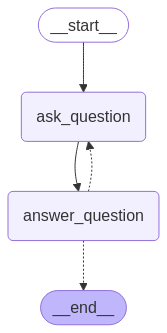

In [24]:
from IPython.display import Image, display

try:
    display(Image(interview_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
final_step = None

initial_state = {
    "editor": perspectives.editors[0],
    "messages": [
        AIMessage(
            content=f"So you said you were writing an article on {example_topic}?",
            name="Subject_Matter_Expert",
        )
    ],
}
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name]["messages"])[:300])
final_step = step

ask_question
--  [AIMessage(content="Yes, that's correct. Could you explain how larger token context windows can specifically enhance the relevance of retrieved documents in a RAG framework?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 239, 'tota
answer_question
--  [AIMessage(content="Larger token context windows in Retrieval-Augmented Generation (RAG) frameworks significantly enhance the relevance of retrieved documents by providing a more comprehensive context for understanding queries and documents. Traditional language models have been limited by smaller c
ask_question
--  [AIMessage(content='Thank you for explaining that. How do larger context windows contribute to the reduction of cognitive load in comprehension tasks within the RAG framework?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 557, 'to
answer_question
--  [AIMessage(content='Lar

In [26]:
final_state = next(iter(final_step.values()))

In [27]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a Wikipedia writer. You have gathered information from experts and search engines. Now, you are refining the outline of the Wikipedia page. \
You need to make sure that the outline is comprehensive and specific. \
Topic you are writing about: {topic} 

Old outline:

{old_outline}""",
        ),
        (
            "user",
            "Refine the outline based on your conversations with subject-matter experts:\n\nConversations:\n\n{conversations}\n\nWrite the refined Wikipedia outline:",
        ),
    ]
)

# Using turbo preview since the context can get quite long
refine_outline_chain = refine_outline_prompt | llm.with_structured_output(
    Outline
)

In [28]:
refined_outline = refine_outline_chain.invoke(
    {
        "topic": example_topic,
        "old_outline": initial_outline.as_str,
        "conversations": "\n\n".join(
            f"### {m.name}\n\n{m.content}" for m in final_state["messages"]
        ),
    }
)

In [29]:
print(refined_outline.as_str)

# Impact of Million-Plus Token Context Window Language Models on Retrieval-Augmented Generation (RAG)

## Introduction

This section introduces the article's focus on the impact of million-plus token context windows in language models, defining key concepts and explaining their significance.

### Overview of Language Models

A discussion on the evolution of language models and their significance in natural language processing.

### Understanding Context Windows

An explanation of context windows within language models, emphasizing the importance of their size.

### Introduction to Retrieval-Augmented Generation (RAG)

A description of RAG, its role in improving language model outputs, and its applications across different fields.

## Advancements in Context Window Sizes

Exploration of technological and research advancements that enabled the development of language models with expansive context windows.

### Technological Developments

An overview of technological advancements that fac

In [30]:
from langchain_community.vectorstores import InMemoryVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
reference_docs = [
    Document(page_content=v, metadata={"source": k})
    for k, v in final_state["references"].items()
]
# This really doesn't need to be a vectorstore for this size of data.
# It could just be a numpy matrix. Or you could store documents
# across requests if you want.
vectorstore = InMemoryVectorStore.from_documents(
    reference_docs,
    embedding=embeddings,
)
retriever = vectorstore.as_retriever(k=3)

In [31]:
retriever.invoke("What's a long context LLM anyway?")

[]

In [32]:
class SubSection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    content: str = Field(
        ...,
        title="Full content of the subsection. Include [#] citations to the cited sources where relevant.",
    )

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.content}".strip()


class WikiSection(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    content: str = Field(..., title="Full content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )
    citations: List[str] = Field(default_factory=list)

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            subsection.as_str for subsection in self.subsections or []
        )
        citations = "\n".join([f" [{i}] {cit}" for i, cit in enumerate(self.citations)])
        return (
            f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip()
            + f"\n\n{citations}".strip()
        )


section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia writer. Complete your assigned WikiSection from the following outline:\n\n"
            "{outline}\n\nCite your sources, using the following references:\n\n<Documents>\n{docs}\n<Documents>",
        ),
        ("user", "Write the full WikiSection for the {section} section."),
    ]
)


async def retrieve(inputs: dict):
    docs = await retriever.ainvoke(inputs["topic"] + ": " + inputs["section"])
    formatted = "\n".join(
        [
            f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )
    return {"docs": formatted, **inputs}


section_writer = (
    retrieve
    | section_writer_prompt
    | llm.with_structured_output(WikiSection)
)

In [33]:
section = await section_writer.ainvoke(
    {
        "outline": refined_outline.as_str,
        "section": refined_outline.sections[1].section_title,
        "topic": example_topic,
    }
)
print(section.as_str)

## Advancements in Context Window Sizes

The development of language models with large context windows, such as those accommodating over a million tokens, marks a significant milestone in natural language processing. These advancements have been driven by both technological innovations and crucial research breakthroughs that together have transformed the landscape of language modeling, particularly benefiting applications like Retrieval-Augmented Generation (RAG).

### Technological Developments

The increase in context window sizes has been primarily fueled by advancements in computing power and storage solutions. Modern GPUs and TPUs now offer immense processing capabilities, enabling them to handle the complex computations necessary for training and operating models with extensive token capacities. Moreover, breakthroughs in distributed computing have allowed the parallel processing of immense datasets, thereby facilitating the efficient scaling of context windows. Improvements in m

In [34]:
from langchain_core.output_parsers import StrOutputParser

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia author. Write the complete wiki article on {topic} using the following section drafts:\n\n"
            "{draft}\n\nStrictly follow Wikipedia format guidelines.",
        ),
        (
            "user",
            'Write the complete Wiki article using markdown format. Organize citations using footnotes like "[1]",'
            " avoiding duplicates in the footer. Include URLs in the footer.",
        ),
    ]
)

writer = writer_prompt | llm | StrOutputParser()

In [35]:
for tok in writer.stream({"topic": example_topic, "draft": section.as_str}):
    print(tok, end="")

# Impact of Million-Plus Token Context Window Language Models on Retrieval-Augmented Generation

## Advancements in Context Window Sizes

The development of language models with large context windows, including those accommodating over a million tokens, marks a significant milestone in natural language processing. These advancements have been driven by both technological innovations and crucial research breakthroughs, transforming the landscape of language modeling and particularly benefiting applications like Retrieval-Augmented Generation (RAG)[1].

### Technological Developments

The increase in context window sizes has been primarily fueled by advancements in computing power and storage solutions. Modern GPUs and TPUs now offer immense processing capabilities, enabling them to handle the complex computations necessary for training and operating models with extensive token capacities. Additionally, breakthroughs in distributed computing have allowed parallel processing of immense da

In [36]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]
    # The final sections output
    sections: List[WikiSection]
    article: str

In [37]:
import asyncio


async def initialize_research(state: ResearchState):
    topic = state["topic"]
    coros = (
        generate_outline_direct.ainvoke({"topic": topic}),
        survey_subjects.ainvoke(topic),
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        "outline": results[0],
        "editors": results[1].editors,
    }


async def conduct_interviews(state: ResearchState):
    topic = state["topic"]
    initial_states = [
        {
            "editor": editor,
            "messages": [
                AIMessage(
                    content=f"So you said you were writing an article on {topic}?",
                    name="Subject_Matter_Expert",
                )
            ],
        }
        for editor in state["editors"]
    ]
    # We call in to the sub-graph here to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_states)

    return {
        **state,
        "interview_results": interview_results,
    }


def format_conversation(interview_state):
    messages = interview_state["messages"]
    convo = "\n".join(f"{m.name}: {m.content}" for m in messages)
    return f'Conversation with {interview_state["editor"].name}\n\n' + convo


async def refine_outline(state: ResearchState):
    convos = "\n\n".join(
        [
            format_conversation(interview_state)
            for interview_state in state["interview_results"]
        ]
    )

    updated_outline = await refine_outline_chain.ainvoke(
        {
            "topic": state["topic"],
            "old_outline": state["outline"].as_str,
            "conversations": convos,
        }
    )
    return {**state, "outline": updated_outline}


async def index_references(state: ResearchState):
    all_docs = []
    for interview_state in state["interview_results"]:
        reference_docs = [
            Document(page_content=v, metadata={"source": k})
            for k, v in interview_state["references"].items()
        ]
        all_docs.extend(reference_docs)
    await vectorstore.aadd_documents(all_docs)
    return state


async def write_sections(state: ResearchState):
    outline = state["outline"]
    sections = await section_writer.abatch(
        [
            {
                "outline": refined_outline.as_str,
                "section": section.section_title,
                "topic": state["topic"],
            }
            for section in outline.sections
        ]
    )
    return {
        **state,
        "sections": sections,
    }


async def write_article(state: ResearchState):
    topic = state["topic"]
    sections = state["sections"]
    draft = "\n\n".join([section.as_str for section in sections])
    article = await writer.ainvoke({"topic": topic, "draft": draft})
    return {
        **state,
        "article": article,
    }

In [38]:
from langgraph.checkpoint.memory import MemorySaver

builder_of_storm = StateGraph(ResearchState)

nodes = [
    ("init_research", initialize_research),
    ("conduct_interviews", conduct_interviews),
    ("refine_outline", refine_outline),
    ("index_references", index_references),
    ("write_sections", write_sections),
    ("write_article", write_article),
]
for i in range(len(nodes)):
    name, node = nodes[i]
    builder_of_storm.add_node(name, node, retry=RetryPolicy(max_attempts=3))
    if i > 0:
        builder_of_storm.add_edge(nodes[i - 1][0], name)

builder_of_storm.add_edge(START, nodes[0][0])
builder_of_storm.add_edge(nodes[-1][0], END)
storm = builder_of_storm.compile(checkpointer=MemorySaver())

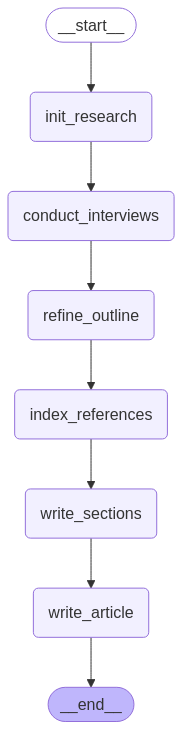

In [39]:
from IPython.display import Image, display

try:
    display(Image(storm.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
config = {"configurable": {"thread_id": "my-thread"}}
async for step in storm.astream(
    {
        "topic": "Groq, NVIDIA, Llamma.cpp and the future of LLM Inference",
    },
    config,
):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name])[:300])

/home/ubuntu/miniforge3/envs/langgraph/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/ubuntu/miniforge3/envs/langgraph/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


init_research
--  {'topic': 'Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', 'outline': Outline(page_title='Groq, NVIDIA, Llamma.cpp, and the Future of LLM Inference', sections=[Section(section_title='Introduction', description='An overview of the key players in the large language model (LLM) inference spa
